# 21.3 Meta-Learner Comparison

**Chapter**: 21 - Meta-Learners  
**Section**: 3 - Comparing S, T, and X Learners  
**Facure Source**: 21-Meta-Learners.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Evaluation Framework](#1-evaluation-framework)
2. [Cumulative Gain Curves](#2-cumulative-gain-curves)
3. [Head-to-Head Comparison](#3-head-to-head-comparison)
4. [Learner Selection Guidelines](#4-learner-selection-guidelines)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

set_notebook_style()
np.random.seed(42)

print("Imports loaded successfully")

Imports loaded successfully


In [2]:
# Load data
train = load_facure_data('invest_email_biased.csv')
test = load_facure_data('invest_email_rnd.csv')

y = 'converted'
T = 'em1'
X = ['age', 'income', 'insurance', 'invested']

print(f"Training: {len(train):,} (biased/observational)")
print(f"Testing:  {len(test):,} (randomized)")

Training: 15,000 (biased/observational)
Testing:  15,000 (randomized)


---

## 1. Facure's Intuition: Evaluation Framework

> **The fundamental problem**: We can't observe individual treatment effects $\tau_i = Y_i(1) - Y_i(0)$.

So how do we evaluate CATE estimators?

### Evaluation Approaches

| Method | Requirements | What It Measures |
|--------|-------------|------------------|
| Cumulative Gain | RCT test data | Targeting quality |
| AUUC | RCT test data | Area under uplift curve |
| Qini Coefficient | RCT test data | Similar to AUUC |
| Simulation | Known DGP | Direct RMSE on $\tau(x)$ |

**Key insight**: With RCT data, we can evaluate *ranking* quality even without observing individual $\tau_i$.

In [3]:
def cumulative_gain(df, cate_col, y_col, t_col, steps=100):
    """
    Compute cumulative gain curve.
    
    Orders units by predicted CATE (highest first), then computes
    cumulative treatment effect as we include more units.
    
    Higher curve = better targeting.
    """
    df_sorted = df.sort_values(cate_col, ascending=False).reset_index(drop=True)
    n = len(df_sorted)
    gains = [0]
    
    for pct in np.linspace(1, 100, steps-1):
        n_top = max(1, int(n * pct / 100))
        top = df_sorted.head(n_top)
        
        treated = top[top[t_col] == 1][y_col]
        control = top[top[t_col] == 0][y_col]
        
        if len(treated) > 0 and len(control) > 0:
            effect = treated.mean() - control.mean()
        else:
            effect = 0
        
        gains.append(effect * (pct / 100))
    
    return np.array(gains)


def auuc(gains):
    """Area Under Uplift Curve."""
    return np.trapezoid(gains, np.linspace(0, 100, len(gains)))


# ATE baseline
ate_test = test[test[T]==1][y].mean() - test[test[T]==0][y].mean()
print(f"ATE in test set: {ate_test:.4f}")

ATE in test set: 0.0685


---

## 2. Formal Treatment: Cumulative Gain Curves

### Implementing All Three Learners

In [4]:
# S-Learner
np.random.seed(123)
s_model = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)
s_model.fit(train[X + [T]], train[y])

def s_learner_predict(model, df, X, T):
    df_t1 = df[X].copy()
    df_t1[T] = 1
    df_t0 = df[X].copy()
    df_t0[T] = 0
    return model.predict(df_t1) - model.predict(df_t0)

cate_s = s_learner_predict(s_model, test, X, T)
print(f"S-Learner: mean CATE = {cate_s.mean():.4f}")

S-Learner: mean CATE = 0.0866


In [5]:
# T-Learner
np.random.seed(123)
m0 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)
m1 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

cate_t = m1.predict(test[X]) - m0.predict(test[X])
print(f"T-Learner: mean CATE = {cate_t.mean():.4f}")

T-Learner: mean CATE = 0.0966


In [6]:
# X-Learner
np.random.seed(123)

# Stage 1 (reuse T-learner models)
g = LogisticRegression(max_iter=1000)
g.fit(train[X], train[T])

# Stage 2
d_train = np.where(
    train[T] == 0,
    m1.predict(train[X]) - train[y],
    train[y] - m0.predict(train[X])
)

mx0 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)
mx1 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)
mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1])

ps = g.predict_proba(test[X])[:, 1]
cate_x = ps * mx0.predict(test[X]) + (1 - ps) * mx1.predict(test[X])
print(f"X-Learner: mean CATE = {cate_x.mean():.4f}")

X-Learner: mean CATE = 0.0996


In [7]:
# Compute cumulative gains
test_s = test.assign(cate=cate_s)
test_t = test.assign(cate=cate_t)
test_x = test.assign(cate=cate_x)

gain_s = cumulative_gain(test_s, 'cate', y, T)
gain_t = cumulative_gain(test_t, 'cate', y, T)
gain_x = cumulative_gain(test_x, 'cate', y, T)

print("Area Under Uplift Curve (AUUC):")
print(f"  S-Learner: {auuc(gain_s):.4f}")
print(f"  T-Learner: {auuc(gain_t):.4f}")
print(f"  X-Learner: {auuc(gain_x):.4f}")

Area Under Uplift Curve (AUUC):
  S-Learner: 4.3758
  T-Learner: 4.4930
  X-Learner: 4.5394


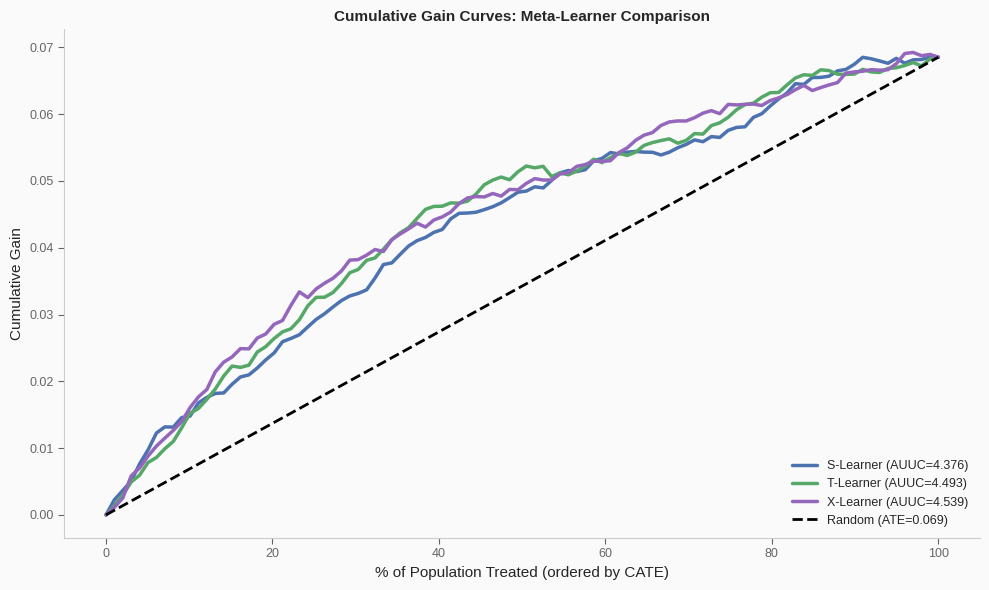

In [8]:
# Plot comparison
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

pct = np.linspace(0, 100, 100)
ax.plot(pct, gain_s, c=COLORS['blue'], lw=2.5, label=f'S-Learner (AUUC={auuc(gain_s):.3f})')
ax.plot(pct, gain_t, c=COLORS['green'], lw=2.5, label=f'T-Learner (AUUC={auuc(gain_t):.3f})')
ax.plot(pct, gain_x, c=COLORS['purple'], lw=2.5, label=f'X-Learner (AUUC={auuc(gain_x):.3f})')
ax.plot([0, 100], [0, ate_test], c='black', ls='--', lw=2, label=f'Random (ATE={ate_test:.3f})')

ax.set_xlabel('% of Population Treated (ordered by CATE)', fontsize=11)
ax.set_ylabel('Cumulative Gain', fontsize=11)
ax.set_title('Cumulative Gain Curves: Meta-Learner Comparison', fontweight='bold')
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

---

## 3. Numeric Demonstration: Head-to-Head Comparison

Let's look at how the learners rank individuals differently.

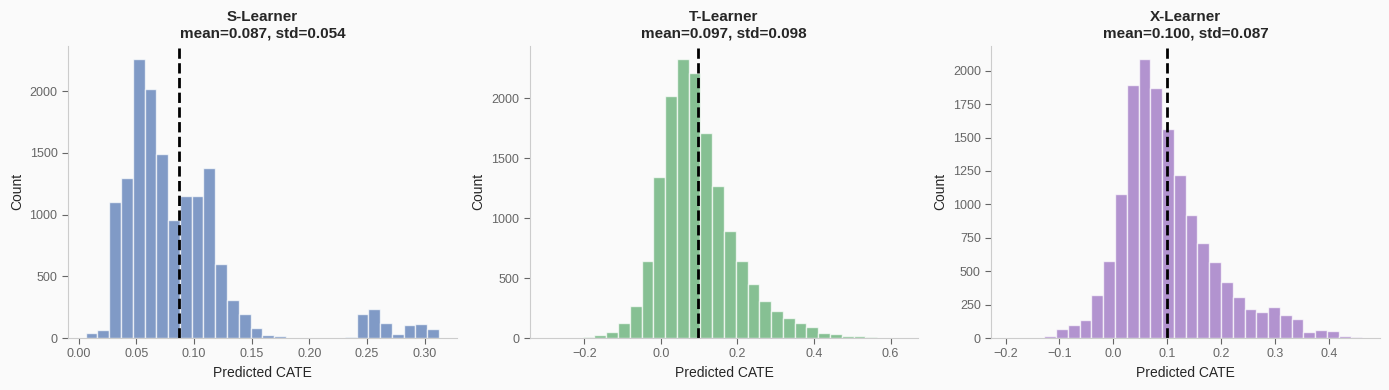

In [9]:
# Compare CATE distributions
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

for ax, cate, name, color in [
    (axes[0], cate_s, 'S-Learner', COLORS['blue']),
    (axes[1], cate_t, 'T-Learner', COLORS['green']),
    (axes[2], cate_x, 'X-Learner', COLORS['purple']),
]:
    ax.hist(cate, bins=30, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(cate.mean(), c='black', ls='--', lw=2)
    ax.set_xlabel('Predicted CATE')
    ax.set_ylabel('Count')
    ax.set_title(f'{name}\nmean={cate.mean():.3f}, std={cate.std():.3f}', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
# Rank correlation between learners
from scipy.stats import spearmanr

corr_st, _ = spearmanr(cate_s, cate_t)
corr_sx, _ = spearmanr(cate_s, cate_x)
corr_tx, _ = spearmanr(cate_t, cate_x)

print("Spearman Rank Correlations:")
print(f"  S vs T: {corr_st:.3f}")
print(f"  S vs X: {corr_sx:.3f}")
print(f"  T vs X: {corr_tx:.3f}")

Spearman Rank Correlations:
  S vs T: 0.580
  S vs X: 0.668
  T vs X: 0.882


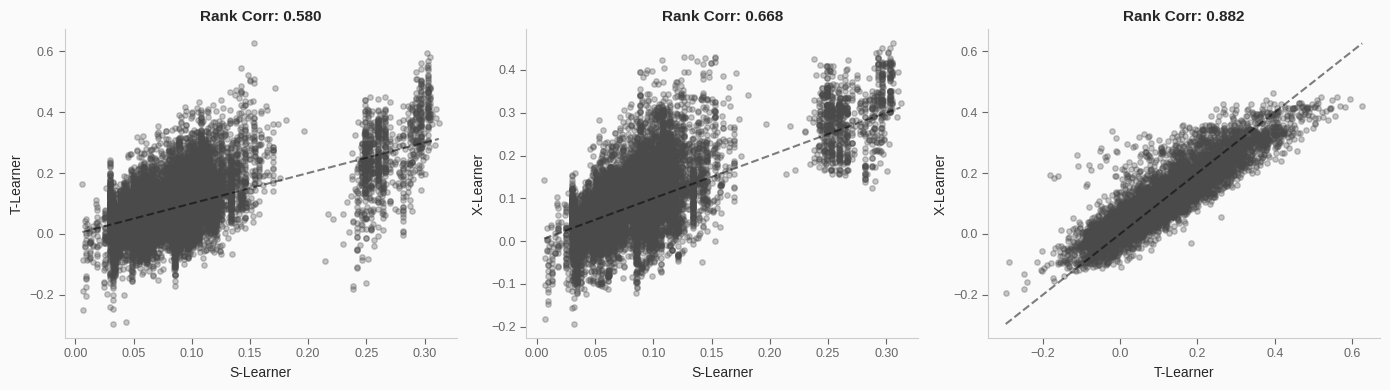

In [11]:
# Scatter plots
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

for ax, (c1, c2, n1, n2) in zip(axes, [
    (cate_s, cate_t, 'S-Learner', 'T-Learner'),
    (cate_s, cate_x, 'S-Learner', 'X-Learner'),
    (cate_t, cate_x, 'T-Learner', 'X-Learner'),
]):
    ax.scatter(c1, c2, alpha=0.3, s=15, c=TUFTE_PALETTE['primary'])
    ax.plot([c1.min(), c1.max()], [c1.min(), c1.max()], 'k--', lw=1.5, alpha=0.5)
    ax.set_xlabel(n1)
    ax.set_ylabel(n2)
    corr, _ = spearmanr(c1, c2)
    ax.set_title(f'Rank Corr: {corr:.3f}', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Implementation: Learner Selection Guidelines

```
Meta-Learner Selection Guide ─────────────────────────────────

┌─────────────────┐
│ Is treatment    │
│ continuous?     │
└────────┬────────┘
         │
    ┌────┴────┐
    │         │
   YES        NO
    │         │
    ▼         ▼
┌────────┐ ┌─────────────────┐
│S-Learner│ │ Are treatment   │
│or       │ │ groups balanced?│
│R-Learner│ └────────┬────────┘
└─────────┘          │
                ┌────┴────┐
                │         │
               YES        NO
                │         │
                ▼         ▼
         ┌──────────┐ ┌────────┐
         │T-Learner │ │X-Learner│
         │or        │ │(handles │
         │S-Learner │ │imbalance)│
         └──────────┘ └─────────┘

Additional Considerations:

• S-Learner:
  - Try first (simplest)
  - Check if treatment feature is kept/used
  - Watch for regularization bias

• T-Learner:
  - Good when groups similar size
  - Each model uses less data
  - Can overfit with small groups

• X-Learner:
  - Best for imbalanced groups
  - More complex, more robust
  - Requires propensity model

• R-Learner (next notebook):
  - Most robust (orthogonal)
  - Works with continuous T
  - Connection to DML
──────────────────────────────────────────────────────────────
```

In [12]:
# Summary table
summary = pd.DataFrame({
    'Learner': ['S-Learner', 'T-Learner', 'X-Learner'],
    'Mean CATE': [cate_s.mean(), cate_t.mean(), cate_x.mean()],
    'Std CATE': [cate_s.std(), cate_t.std(), cate_x.std()],
    'AUUC': [auuc(gain_s), auuc(gain_t), auuc(gain_x)],
    'Complexity': ['Low', 'Medium', 'High'],
    'Continuous T': ['Yes', 'No', 'No'],
})

print("Meta-Learner Summary:")
print(summary.to_string(index=False))

Meta-Learner Summary:
  Learner  Mean CATE  Std CATE   AUUC Complexity Continuous T
S-Learner     0.0866    0.0543 4.3758        Low          Yes
T-Learner     0.0966    0.0982 4.4930     Medium           No
X-Learner     0.0996    0.0874 4.5394       High           No


---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5)**: *"How would you evaluate a CATE model if you have access to RCT data?"*

<details>
<summary>Solution</summary>

**Key approaches with RCT data**:

1. **Cumulative Gain / Uplift Curves**:
   - Sort test units by predicted CATE (highest first)
   - Compute cumulative ATE as you include more units
   - Higher curve = better targeting
   - AUUC (Area Under Uplift Curve) as single metric

2. **Qini Coefficient**:
   - Similar to AUUC, normalized differently
   - Compares to random targeting baseline

3. **Group-wise ATE**:
   - Split by CATE quantiles (e.g., Q1-Q4)
   - Compute ATE within each group
   - Good model: High CATE group has high realized ATE

4. **Calibration**:
   - Plot predicted CATE vs. realized CATE by bins
   - Perfect calibration: 45-degree line

**Why RCT matters**: In RCT, $T \perp\!\!\!\perp X$, so we can compute unbiased group ATEs.

</details>

---

**Q2 (Netflix, Senior DS)**: *"When would you use X-learner over T-learner?"*

<details>
<summary>Solution</summary>

**Use X-learner when**:

1. **Treatment groups are imbalanced** (main reason)
   - Example: 10% treated, 90% control
   - T-learner suffers from different regularization levels
   - X-learner uses propensity weighting to correct

2. **You have a good propensity model**
   - X-learner requires estimating $e(x) = P(T=1|X)$
   - If propensity is hard to model, benefit may be limited

3. **True CATE has similar complexity across groups**
   - X-learner assumes the treatment effect function is similar
   - Propensity weighting blends two effect models

**Use T-learner when**:
- Groups are balanced
- Outcome models differ fundamentally by treatment status
- Simpler model is sufficient

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 21: "Meta-Learners."

[^2]: Kunzel, S. R. et al. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*.

[^3]: Gutierrez, P. and Gerardy, J. Y. (2017). Causal Inference and Uplift Modelling: A Review. *JMLR Workshop*.

---

**Next**: [04. R-Learner Introduction](./04_r_learner_intro.ipynb) — The orthogonal learner and bridge to DML